# Feature Selection

Here, I want to apply what I learnt in [Introduction to Statistical Learning](https://www.statlearning.com/) Chapter 6 about Feature Selection. This also answers some of my questions in the Least Squares / Logistic Regression files.

In [65]:
import pandas as pd
import numpy as np
import itertools
import statsmodels.api as sm
from ISLP.models import (ModelSpec as MS, summarize, poly)
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import \
     (cross_validate,
      KFold)

df = pd.read_csv("../train.csv")
print(df.shape)
print(df.columns)
print(df.dtypes)
for col in df.columns:
    print("Missing rows in {0}:".format(col), df[col].shape[0] - df[col].count())
print(df.describe())

y = df['Survived']

(891, 12)
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object
Missing rows in PassengerId: 0
Missing rows in Survived: 0
Missing rows in Pclass: 0
Missing rows in Name: 0
Missing rows in Sex: 0
Missing rows in Age: 177
Missing rows in SibSp: 0
Missing rows in Parch: 0
Missing rows in Ticket: 0
Missing rows in Fare: 0
Missing rows in Cabin: 687
Missing rows in Embarked: 2
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.4

First of all, I have to do some preprocessing:

In [66]:
df['Sex'] = df['Sex'].astype('category')
df['SexNr'] = df['Sex'].cat.codes

mean = np.mean(df['Age'])
df['Age'] = df['Age'].fillna(mean)

df['Embarked'] = df['Embarked'].astype('category')

print(df.dtypes)

PassengerId       int64
Survived          int64
Pclass            int64
Name             object
Sex            category
Age             float64
SibSp             int64
Parch             int64
Ticket           object
Fare            float64
Cabin            object
Embarked       category
SexNr              int8
dtype: object


## Best Subset Selection

1. Generate all best models with 0 to p predictors.

In [67]:
predictors = ['Pclass', 'SexNr', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

for p in range(0, len(predictors)+1):
    print('Anzahl an Predictors:', p)
    best_r2 = 0
    best_predictors = ()
    for combination in itertools.combinations(predictors, p):
        X = MS(list(combination)).fit_transform(df)
        results = sm.OLS(y,X, missing='drop').fit()
        #print(summarize(results))
        #print("Rsquared:", results.rsquared)
        if results.rsquared > best_r2:
            best_r2 = results.rsquared
            best_predictors = (combination)
    print('Beste Kombination:', combination, 'mit R^2:', best_r2)

Anzahl an Predictors: 0
Beste Kombination: () mit R^2: 0
Anzahl an Predictors: 1
Beste Kombination: ('Embarked',) mit R^2: 0.2952307228626888
Anzahl an Predictors: 2
Beste Kombination: ('Fare', 'Embarked') mit R^2: 0.36768020891350406
Anzahl an Predictors: 3
Beste Kombination: ('Parch', 'Fare', 'Embarked') mit R^2: 0.38336856306416056
Anzahl an Predictors: 4
Beste Kombination: ('SibSp', 'Parch', 'Fare', 'Embarked') mit R^2: 0.39326065634846097
Anzahl an Predictors: 5
Beste Kombination: ('Age', 'SibSp', 'Parch', 'Fare', 'Embarked') mit R^2: 0.3974572876555986
Anzahl an Predictors: 6
Beste Kombination: ('SexNr', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked') mit R^2: 0.3978260472917734
Anzahl an Predictors: 7
Beste Kombination: ('Pclass', 'SexNr', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked') mit R^2: 0.39834629200884475


This works for now, but 'Embarked' as a categorical value with 3 options is probably not implemented properly, since it only counts as one variable for my code, while it is implemented as two variables in the model. I will ignore that for now and see whether that is talked about later in the Book Chapter or in the Lab.

### Using BIC, AIC and adjusted R^2

Another problem with this is that the R^2 is measured on the training set instead of a test set, since I don't have a dedicated test set. Another problem is also that since the model all have different sizes, you actually can't really use R^2 (it will always be lower with more predictors). The solution for that is to another measure. When having implemented that, I can properly rely on the model error. Below, I have implemented AIC, BIC and the adjusted R^2.

(Note: We use R^2 to choose the best model between all models with the same numbers of predictors. This is fine, since comparing R^2 between moelds of the same size makes sense.)

Anzahl an Predictors: 0
Beste Kombination: () mit R^2: 0
Anzahl an Predictors: 1
Beste Kombination: ('SexNr',) mit R^2: 0.2952307228626888
Anzahl an Predictors: 2
Beste Kombination: ('Pclass', 'SexNr') mit R^2: 0.36768020891350406
Anzahl an Predictors: 3
Beste Kombination: ('Pclass', 'SexNr', 'Age') mit R^2: 0.38336856306416056
Anzahl an Predictors: 4
Beste Kombination: ('Pclass', 'SexNr', 'Age', 'SibSp') mit R^2: 0.39326065634846097
Anzahl an Predictors: 5
Beste Kombination: ('Pclass', 'SexNr', 'Age', 'SibSp', 'Embarked') mit R^2: 0.3974572876555986
Anzahl an Predictors: 6
Beste Kombination: ('Pclass', 'SexNr', 'Age', 'SibSp', 'Parch', 'Embarked') mit R^2: 0.3978260472917734
Anzahl an Predictors: 7
Beste Kombination: ('Pclass', 'SexNr', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked') mit R^2: 0.39834629200884475


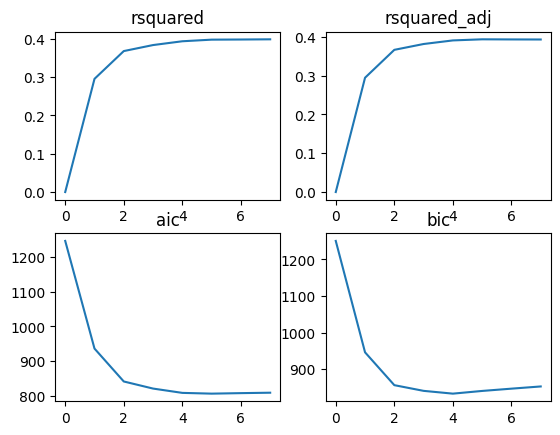

In [68]:
predictors = ['Pclass', 'SexNr', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

rsquared = []
rsquared_adj = []
aic = []
bic = []
for p in range(0, len(predictors)+1):
    print('Anzahl an Predictors:', p)
    best_r2 = 0
    best_predictors = ()
    for combination in itertools.combinations(predictors, p):
        X = MS(list(combination)).fit_transform(df)
        results = sm.OLS(y,X, missing='drop').fit()
        #print(summarize(results))
        #print("Rsquared:", results.rsquared)
        if results.rsquared > best_r2:
            best_r2 = results.rsquared
            best_predictors = combination
    print('Beste Kombination:', best_predictors, 'mit R^2:', best_r2)
    rsquared.append(best_r2)

    X = MS(list(best_predictors)).fit_transform(df)
    results = sm.OLS(y,X, missing='drop').fit()
    rsquared_adj.append(results.rsquared_adj)
    aic.append(results.aic)
    bic.append(results.bic)

y_results = ["rsquared", "rsquared_adj", "aic", "bic"]
xcoord = [0,0,1,1]
fig, axs = plt.subplots(2,2)
for id, name in enumerate([rsquared, rsquared_adj, aic, bic]):
    axs[xcoord[id], id%2].plot(range(0, len(predictors)+1), name)
    axs[xcoord[id], id%2].set_title(y_results[id])
plt.show()

## Forward Stepwise Selection

I'm keeping the implementation of BIC, AIC and adjusted R^2 and their visualizations.

Dazu gekommen: SexNr mit R^2: 0.2952307228626888
Dazu gekommen: Pclass mit R^2: 0.36768020891350417
Dazu gekommen: Age mit R^2: 0.38336856306416056
Dazu gekommen: SibSp mit R^2: 0.3932606563484611
Dazu gekommen: Fare mit R^2: 0.3941011990871931
Dazu gekommen: Parch mit R^2: 0.3949290844484469


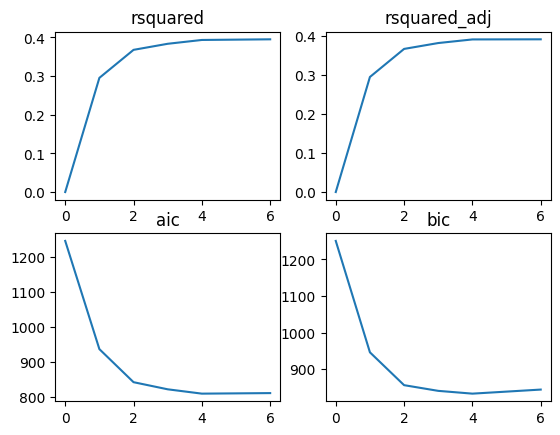

In [89]:
predictors_noEmb = ['Pclass', 'SexNr', 'Age', 'SibSp', 'Parch', 'Fare'] # Embarked
remaining_predictors = predictors_noEmb.copy()

rsquared_forward = []
rsquared_adj_forward = []
aic_forward = []
bic_forward = []

# first iteration
X = MS([]).fit_transform(df)
results = sm.OLS(y,X, missing='drop').fit()
rsquared_forward.append(results.rsquared)
rsquared_adj_forward.append(results.rsquared_adj)
aic_forward.append(results.aic)
bic_forward.append(results.bic)
for p in range(0, len(predictors_noEmb)):
    best_r2 = 0
    new_predictor = ''
    for predictor in remaining_predictors:
        X_2 = X.copy()
        X_2[predictor] = df[predictor]
        results = sm.OLS(y,X_2, missing='drop').fit()
        if results.rsquared > best_r2:
            best_r2 = results.rsquared
            new_predictor = predictor
    print('Dazu gekommen:', new_predictor, 'mit R^2:', best_r2)
    remaining_predictors.remove(new_predictor)

    # adding the predictor and calculating new so the best results get saved
    X[new_predictor] = df[new_predictor]
    results = sm.OLS(y,X, missing='drop').fit()
    rsquared_forward.append(results.rsquared)
    rsquared_adj_forward.append(results.rsquared_adj)
    aic_forward.append(results.aic)
    bic_forward.append(results.bic)


y_results = ["rsquared", "rsquared_adj", "aic", "bic"]
xcoord = [0,0,1,1]
fig, axs = plt.subplots(2,2)
for id, name in enumerate([rsquared_forward, rsquared_adj_forward, aic_forward, bic_forward]):
    axs[xcoord[id], id%2].plot(range(0, len(predictors_noEmb)+1), name)
    axs[xcoord[id], id%2].set_title(y_results[id])
plt.show()

Now I've run into a problem. Because I haven't transformed the categorical value 'Embarked' into dummy variables from the start, I can now not use it easily. I might solve that later, but for now I want to compare the different graphs.

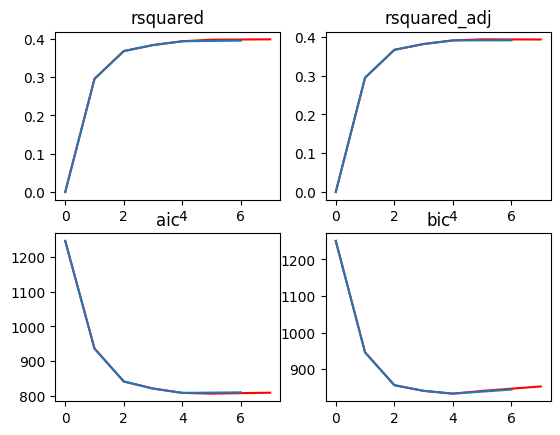

In [90]:
predictors = ['Pclass', 'SexNr', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
y_results = ["rsquared", "rsquared_adj", "aic", "bic"]
xcoord = [0,0,1,1]
fig, axs = plt.subplots(2,2)

for id, name in enumerate([rsquared, rsquared_adj, aic, bic]):
    axs[xcoord[id], id%2].plot(range(0, len(predictors)+1), name, c='red')
    axs[xcoord[id], id%2].set_title(y_results[id])

predictors_noEmb = ['Pclass', 'SexNr', 'Age', 'SibSp', 'Parch', 'Fare'] # Embarked

for id, name in enumerate([rsquared_forward, rsquared_adj_forward, aic_forward, bic_forward]):
    axs[xcoord[id], id%2].plot(range(0, len(predictors_noEmb)+1), name)
plt.show()

There seems to be no discernible distance between the two. This is to be expected, since Best Subset Selection chose the same pairs as stepwise selection did. The lowest AIC and BIC is at 4 predictors, indicating it might be good to use 3 or even 2 predictors.

## Backward Stepwise Selection

Index(['intercept', 'Pclass', 'SexNr', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked[Q]', 'Embarked[S]'],
      dtype='object')
Iteration
Iteration
Iteration
Iteration
Iteration
Iteration
Iteration
Iteration
Weg gekommen: Embarked[Q] mit jetzigem R^2: 0.39834492351550166
Iteration
Iteration
Iteration
Iteration
Iteration
Iteration
Iteration
Weg gekommen: Parch mit jetzigem R^2: 0.39781924919827394
Iteration
Iteration
Iteration
Iteration
Iteration
Iteration
Weg gekommen: Fare mit jetzigem R^2: 0.3974551011689059
Iteration
Iteration
Iteration
Iteration
Iteration
Weg gekommen: Embarked[S] mit jetzigem R^2: 0.39326065634846097
Iteration
Iteration
Iteration
Iteration
Weg gekommen: SibSp mit jetzigem R^2: 0.38336856306416056
Iteration
Iteration
Iteration
Weg gekommen: Age mit jetzigem R^2: 0.36768020891350406
Iteration
Iteration
Weg gekommen: Pclass mit jetzigem R^2: 0.2952307228626888


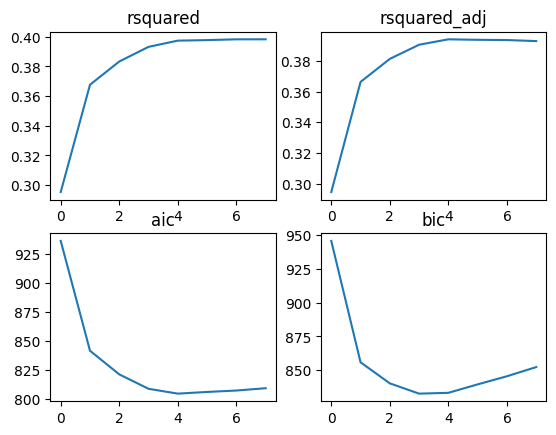

In [91]:
rsquared_backward = []
rsquared_adj_backward = []
aic_backward = []
bic_backward = []

# first fit: all variables
X = MS(predictors).fit_transform(df)
print(X.columns)
results = sm.OLS(y,X, missing='drop').fit()
rsquared_backward.append(results.rsquared)
rsquared_adj_backward.append(results.rsquared_adj)
aic_backward.append(results.aic)
bic_backward.append(results.bic)

# second fit
for p in range(0, len(predictors)):
    best_r2 = 0
    lost_predictor = ''
    for predictor in X.loc[:, X.columns!='intercept']:
        X_2 = X.copy()
        X_2 = X_2.drop(predictor, axis=1)
        results = sm.OLS(y,X_2, missing='drop').fit()
        if results.rsquared > best_r2:
            best_r2 = results.rsquared
            lost_predictor = predictor
        print("Iteration")
    print('Weg gekommen:', lost_predictor, 'mit jetzigem R^2:', best_r2)

    # removing the predictor and calculating new so the best results get saved
    X = X.drop(lost_predictor, axis=1)
    results = sm.OLS(y,X, missing='drop').fit()
    rsquared_backward.append(results.rsquared)
    rsquared_adj_backward.append(results.rsquared_adj)
    aic_backward.append(results.aic)
    bic_backward.append(results.bic)

#reverse the results
rsquared_backward.reverse()
rsquared_adj_backward.reverse()
aic_backward.reverse()
bic_backward.reverse()

y_results = ["rsquared", "rsquared_adj", "aic", "bic"]
xcoord = [0,0,1,1]
fig, axs = plt.subplots(2,2)
for id, name in enumerate([rsquared_backward, rsquared_adj_backward, aic_backward, bic_backward]):
    axs[xcoord[id], id%2].plot(range(0, len(predictors)+1), name)
    axs[xcoord[id], id%2].set_title(y_results[id])
plt.show()


And again, I want to implement that into the other graph:

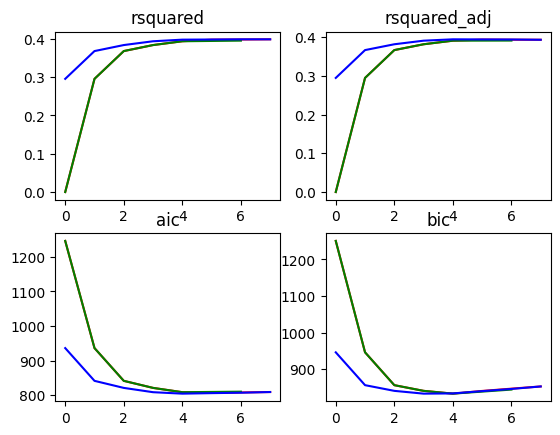

In [93]:
predictors = ['Pclass', 'SexNr', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
predictors_noEmb = ['Pclass', 'SexNr', 'Age', 'SibSp', 'Parch', 'Fare'] # Embarked
y_results = ["rsquared", "rsquared_adj", "aic", "bic"]
xcoord = [0,0,1,1]
fig, axs = plt.subplots(2,2)

for id, name in enumerate([rsquared, rsquared_adj, aic, bic]):
    axs[xcoord[id], id%2].plot(range(0, len(predictors)+1), name, c='red')
    axs[xcoord[id], id%2].set_title(y_results[id])

for id, name in enumerate([rsquared_forward, rsquared_adj_forward, aic_forward, bic_forward]):
    axs[xcoord[id], id%2].plot(range(0, len(predictors_noEmb)+1), name, c='green')

for id, name in enumerate([rsquared_backward, rsquared_adj_backward, aic_backward, bic_backward]):
    axs[xcoord[id], id%2].plot(range(0, len(predictors)+1), name, c='blue')

plt.show()

This poses a problem again, because backward selection (the blue line) is not supposed to have better results than best subset selection (the red line hidden under the green one). This means I've made a mistake.